# Random Forest

## Biblioteca e dados

In [1]:
# Data manipulation
import numpy as np
import pandas as pd
import dask.dataframe as dd 

# Visualization.
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score, precision_score, roc_auc_score, roc_curve, classification_report
from sklearn.preprocessing import StandardScaler, power_transform, MinMaxScaler
from sklearn.feature_selection import  SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier

# Time register (if necessary)
from dask.diagnostics import ProgressBar

# Saving models
from datetime import datetime
import joblib

# Display all columns
pd.set_option('display.max_columns', 150,
             'display.max_rows', 150)

# SHAP 
# !pip install shap
import shap

## Data

In [2]:
df = pd.read_csv("/Users/aurelianosancho/Downloads/Exemplos-main/classificacao_Q2.csv")

In [3]:
print(round(100*df["target"].value_counts(normalize = True),2))

1    50.32
0    49.68
Name: target, dtype: float64


In [4]:
df.dropna(inplace = True)

## Separação e padronização dos dados de treino e teste: completos

In [5]:
# Getting the data:
X = df.drop(['target'], axis = 1)

y = df['target']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 451, test_size= .25, stratify = y)

In [7]:
#var_num = ['total_balance', 'idade_da_divida', 'soma_total_enviado']
#StdSca = MinMaxScaler() ## or standerscaler 
#X_train[var_num] = pd.DataFrame(StdSca.fit_transform(X_train[var_num]), columns = var_num, index = X_train.index)
#X_test[var_num] = pd.DataFrame(StdSca.transform(X_test[var_num]), columns = var_num, index = X_test.index)
#df[var_num] = StdSca.transform(df[var_num])

In [8]:
# Cross validate
skf = StratifiedKFold(n_splits = 5, shuffle = True)

CV = cross_validate(estimator = RandomForestClassifier(class_weight = "balanced", n_estimators = 18, min_samples_split = 20, min_samples_leaf= 10, max_depth = 6, random_state = 451), 
                    cv = skf, 
                    scoring = ["accuracy", "precision", "recall", "f1_macro", "roc_auc"], 
                    return_estimator = True,
                    return_train_score= True,
                    verbose = 2,
                    #n_jobs = 5,
                   X = X_train,
                   y = y_train)

[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=   0.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] ................................................. , total=   0.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished


In [9]:
cv_df = pd.DataFrame(CV)

In [10]:
cv_df

,fit_time,score_time,estimator,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1_macro,train_f1_macro,test_roc_auc,train_roc_auc
0,0.138342,0.031240,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.888000,0.909333,0.896739,0.898327,0.877660,0.924503,0.887993,0.909292,0.945529,0.966884
1,0.138230,0.029730,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.893333,0.914667,0.873737,0.908735,0.920213,0.923179,0.893241,0.914648,0.953521,0.970319
2,0.199038,0.049286,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.901333,0.919333,0.876238,0.915900,0.936508,0.924403,0.901153,0.919325,0.941031,0.974449
3,0.129792,0.040371,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.874667,0.912667,0.869792,0.910408,0.883598,0.916446,0.874635,0.912660,0.926538,0.969635
4,0.111851,0.047226,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.901333,0.920667,0.904255,0.916121,0.899471,0.927056,0.901331,0.920656,0.948768,0.970265


In [11]:
teste = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1_macro', 'test_roc_auc']
for icol in teste:
    print('%s -> mean: %1.2f +- %1.2f' %(icol, cv_df[icol].mean(), cv_df[icol].std()))

test_accuracy -> mean: 0.89 +- 0.01
test_precision -> mean: 0.88 +- 0.02
test_recall -> mean: 0.90 +- 0.02
test_f1_macro -> mean: 0.89 +- 0.01
test_roc_auc -> mean: 0.94 +- 0.01


### Relação Threshold 

In [12]:
print("Média de acurácia de treino dos modelos:", CV["train_accuracy"].mean(), "\n", "Desvio padrão de acurácia de treino dos modelos:", CV["train_accuracy"].std())

Média de acurácia de treino dos modelos: 0.9153333333333332 
 Desvio padrão de acurácia de treino dos modelos: 0.004195235392680606


In [13]:
print("Média de acurácia de teste dos modelos:", CV["test_accuracy"].mean(), "\n", "Desvio padrão de acurácia de teste dos modelos:", CV["test_accuracy"].std())

Média de acurácia de teste dos modelos: 0.8917333333333334 
 Desvio padrão de acurácia de teste dos modelos: 0.00992057346012706


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


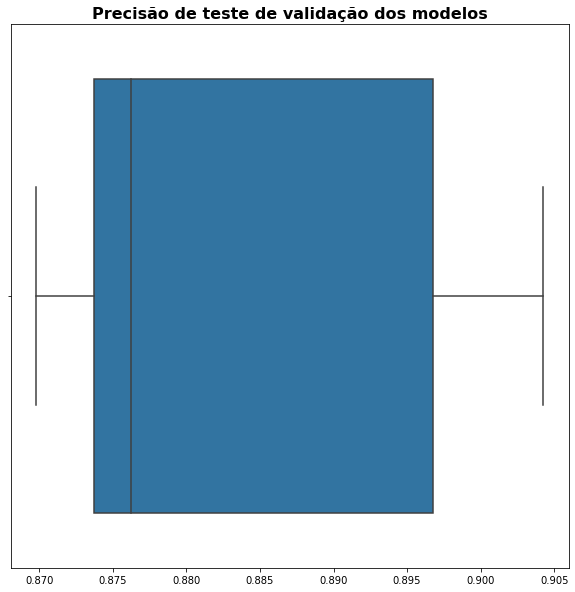

In [14]:
plt.figure(figsize = (10,10))
sns.boxplot(CV["test_precision"])
plt.title("Precisão de teste de validação dos modelos", fontsize = 16, weight = "bold");

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


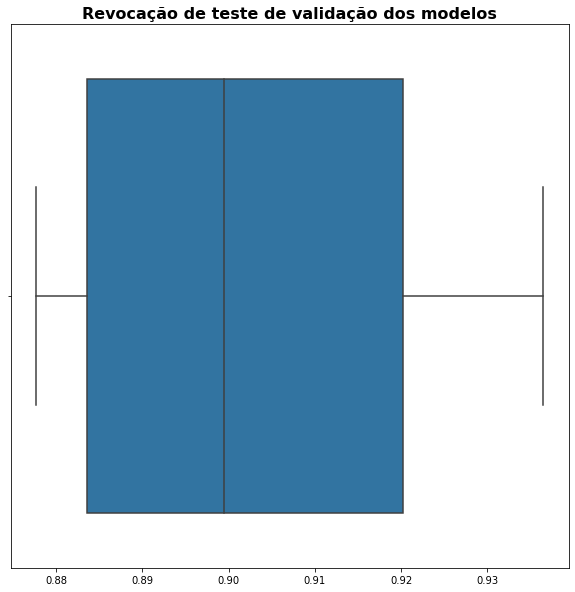

In [15]:
plt.figure(figsize = (10,10))
sns.boxplot(CV["test_recall"])
plt.title("Revocação de teste de validação dos modelos", fontsize = 16, weight = "bold");

In [16]:
CV = CV["estimator"]

## Métricas com dados de teste

### Saídas

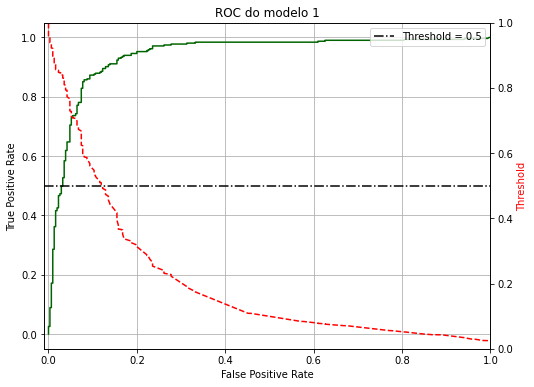

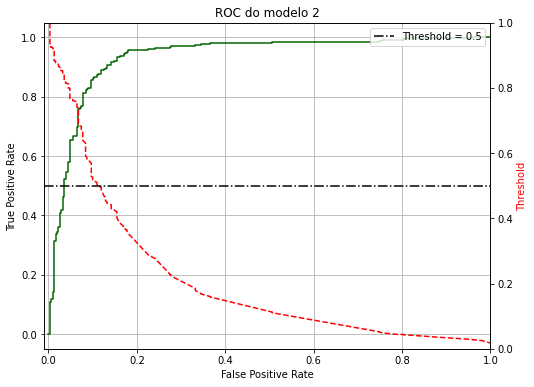

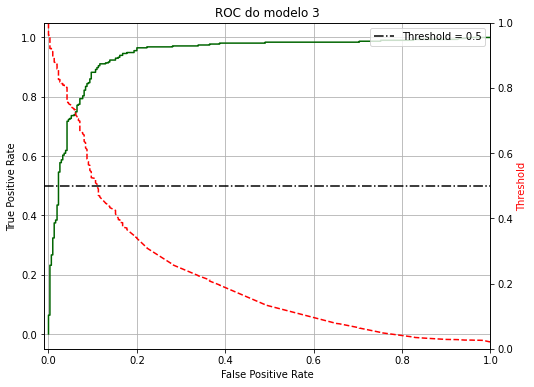

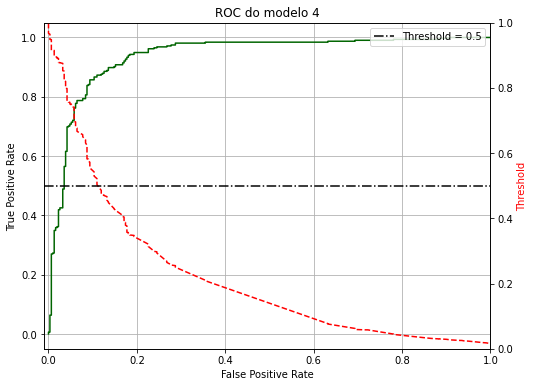

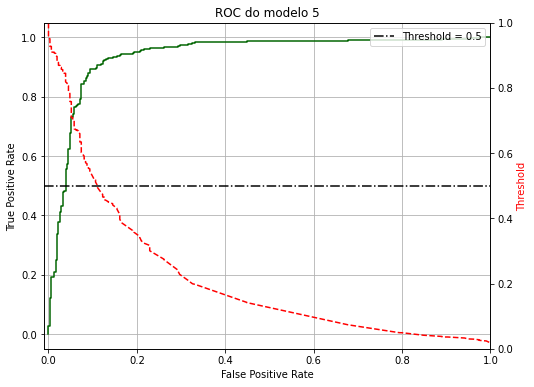

In [17]:
#define metrics
for i in range(5):
    y_pred_proba = CV[i].predict_proba(X_test)[::,1]
    fpr, tpr, sarrafo = roc_curve(y_test,  y_pred_proba)
    sarrafo = sarrafo[fpr <= 1]
    
    #create ROC curve
    plt.figure(figsize = (8,6))
    plt.plot(fpr,tpr, lw = 1.5, color = "darkgreen")
    plt.grid()
    plt.title(f"ROC do modelo {i + 1}")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, sarrafo, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([0,1])
    ax2.set_xlim([-0.01,1])
    ax2.axhline(y = 0.5, lw = 1.5, color = "black", ls = "-.", label = "Threshold = 0.5")
    plt.legend()

    plt.show()

### Métricas.

In [18]:
for i in range(5):
    scores = [accuracy_score(y_test, CV[i].predict(X_test)), 
                             balanced_accuracy_score(y_test, CV[i].predict(X_test)), 
                             f1_score(y_test, CV[i].predict(X_test), average = "macro"), 
                             precision_score(y_test, CV[i].predict(X_test)), 
                             roc_auc_score(y_test, CV[i].predict(X_test))]
    scores_names = ["Acurácia", "Acurácia_balanceada", "F1_macro", "Precisão", "ROC"]
    
    print("Modelo", i + 1)
    print(pd.DataFrame([scores], columns = scores_names))

Modelo 1
   Acurácia  Acurácia_balanceada  F1_macro  Precisão      ROC
0    0.8832              0.88318  0.883189  0.882911  0.88318
Modelo 2
   Acurácia  Acurácia_balanceada  F1_macro  Precisão       ROC
0    0.8816             0.881669    0.8816  0.889968  0.881669
Modelo 3
   Acurácia  Acurácia_balanceada  F1_macro  Precisão      ROC
0    0.8928              0.89278   0.89279  0.892405  0.89278
Modelo 4
   Acurácia  Acurácia_balanceada  F1_macro  Precisão       ROC
0    0.8816             0.881669    0.8816  0.889968  0.881669
Modelo 5
   Acurácia  Acurácia_balanceada  F1_macro  Precisão       ROC
0     0.896             0.895955  0.895983  0.893082  0.895955


### Histograma

In [19]:
predict_model_cols = X_test.columns


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


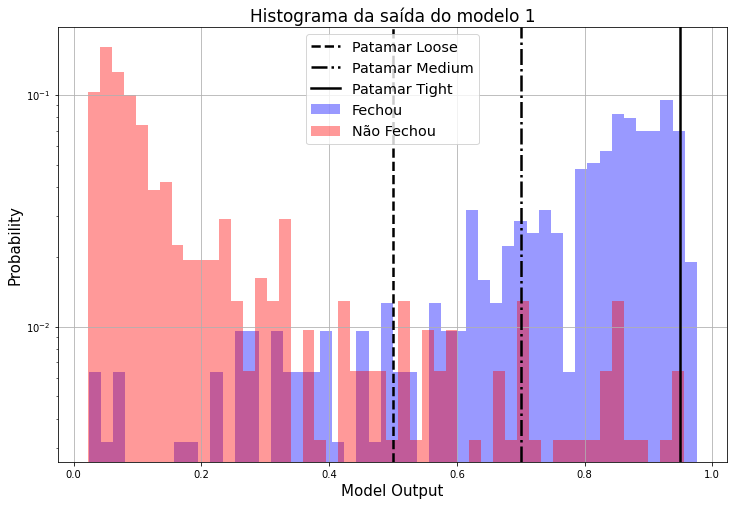


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


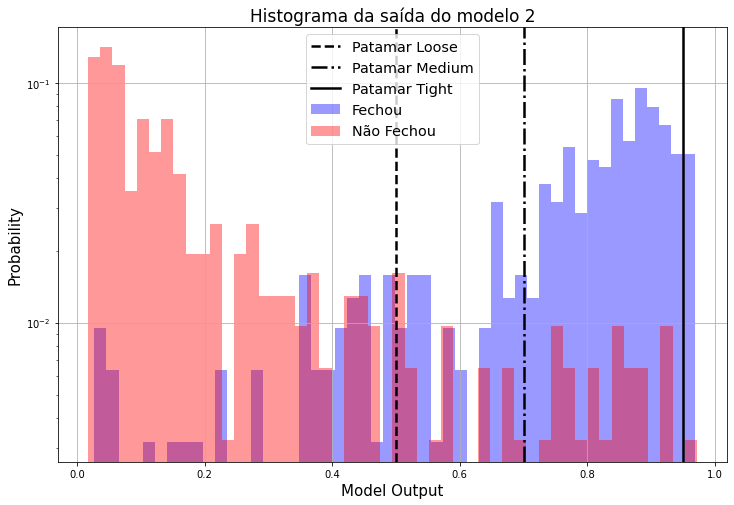


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


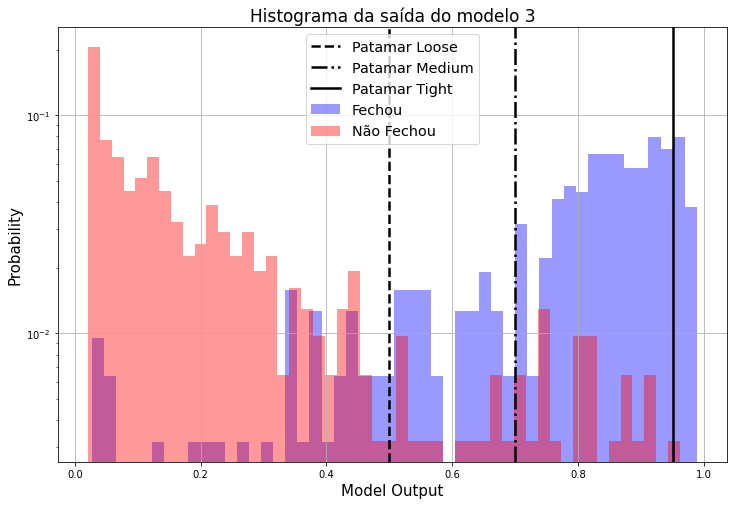


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


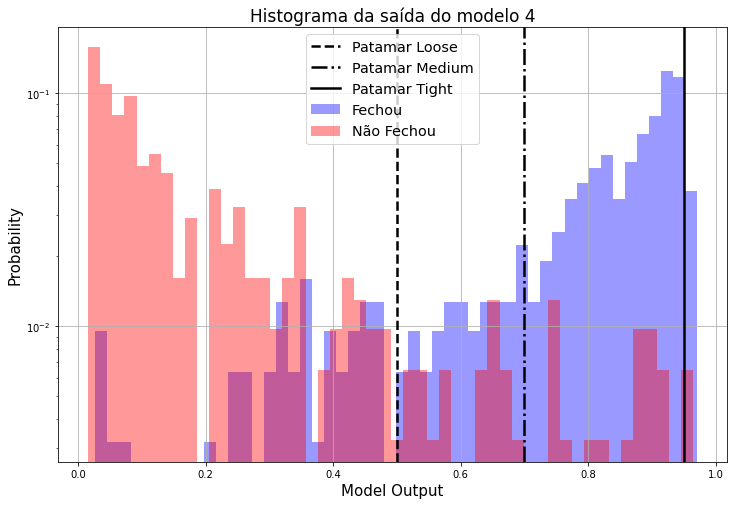


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


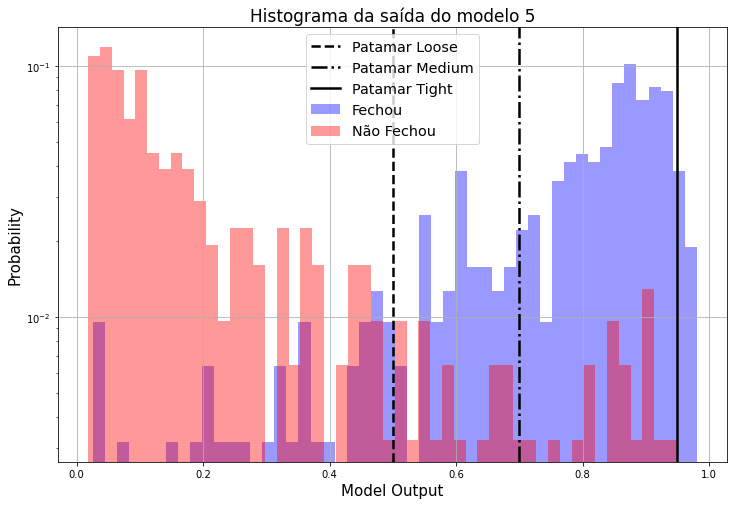

In [20]:
# Histograma
for model_idx in range(5):
    # Separa os valores de teste
    if "probabilidade_model_%i" %(model_idx) not in X_test.columns:
        X_test["probabilidade_model_%i" %(model_idx)] = CV[model_idx].predict_proba(X_test[predict_model_cols])[:,1]
    
    #Figura
    plt.figure(figsize = (12,8))
    # weights for hist 1
    weights_h1 = (np.ones_like(X_test.loc[y_test == 1, "probabilidade_model_%i" %(model_idx)].values)/\
                  len(X_test.loc[y_test == 1, "probabilidade_model_%i" %(model_idx)]))
    # weights for hist 2
    weights_h2 = (np.ones_like(X_test.loc[y_test != 1, "probabilidade_model_%i" %(model_idx)].values)/\
                  len(X_test.loc[y_test != 1, "probabilidade_model_%i" %(model_idx)]))

    plt.hist(X_test.loc[y_test == 1, "probabilidade_model_%i" %(model_idx)], 
             label='Fechou', weights=weights_h1,
             color='blue', bins=50, histtype='stepfilled', lw=1.5, alpha=.4)
    plt.hist(X_test.loc[y_test != 1, "probabilidade_model_%i" %(model_idx)], 
             label='Não Fechou', weights=weights_h2, 
             color='red', bins=50, histtype='stepfilled', lw=1.5, alpha=.4)
    #sns.histplot(x = x_test["probabilidade de pagar"],
    #             hue = y_test)
    plt.ylabel('Probability', fontsize=15)
    plt.xlabel('Model Output', fontsize=15)
    plt.grid()
    plt.title(f"Histograma da saída do modelo {model_idx+1}", fontsize=17) 
    plt.axvline(x=.5, color='black', lw=2.5, ls='--', label='Patamar Loose')
    plt.axvline(x=.7, color='black', lw=2.5, ls='-.', label='Patamar Medium')
    plt.axvline(x=.95, color='black', lw=2.5, ls='-', label='Patamar Tight')
    plt.legend(loc='upper center', fontsize='x-large')
    plt.yscale('log')
    plt.show()

In [21]:
X_test.drop(['probabilidade_model_0', 'probabilidade_model_1', 'probabilidade_model_2',
       'probabilidade_model_3', 'probabilidade_model_4',], axis = 1, inplace = True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Matrizes segundo limiar.

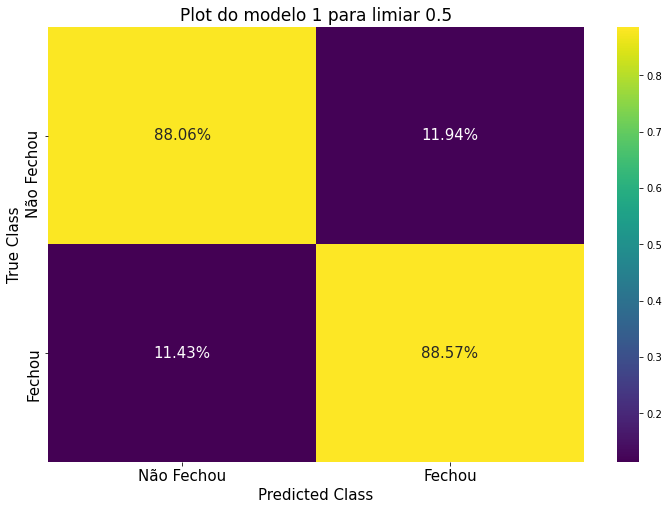

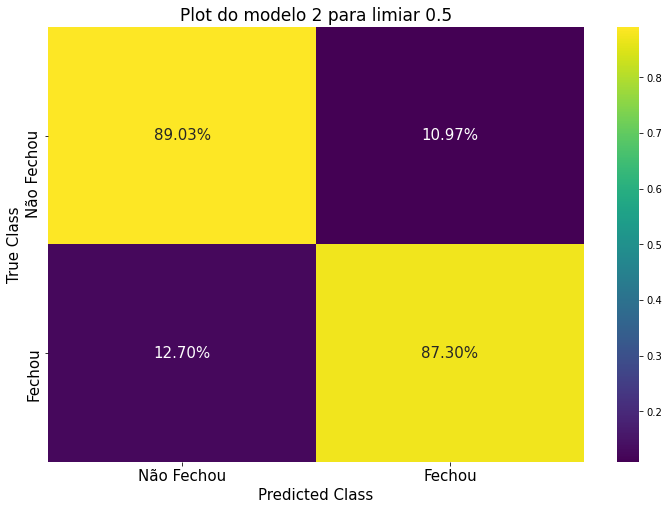

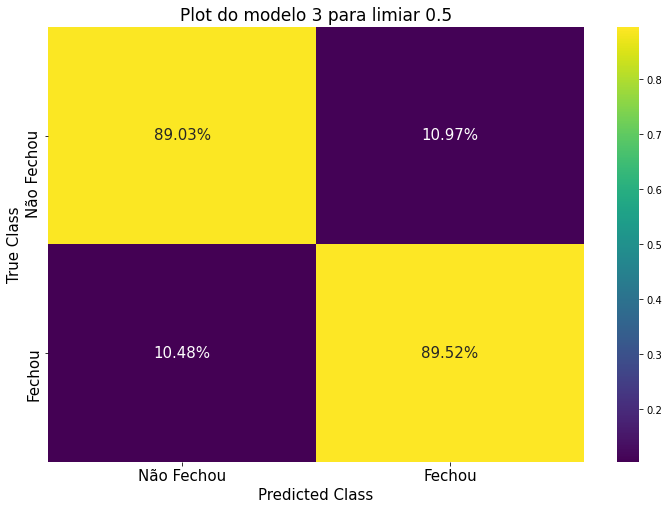

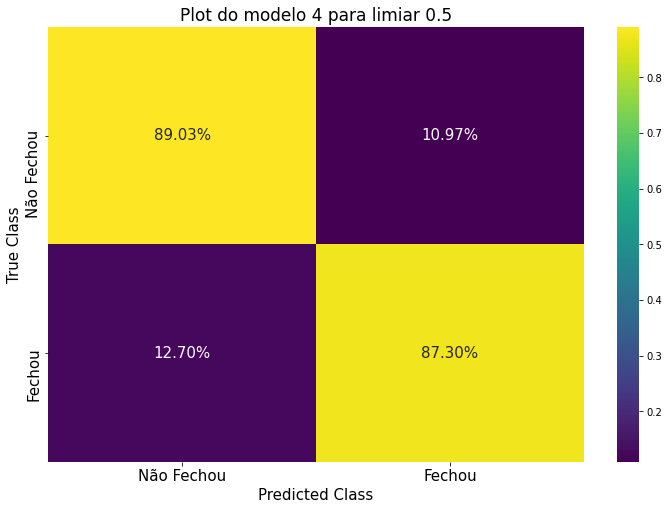

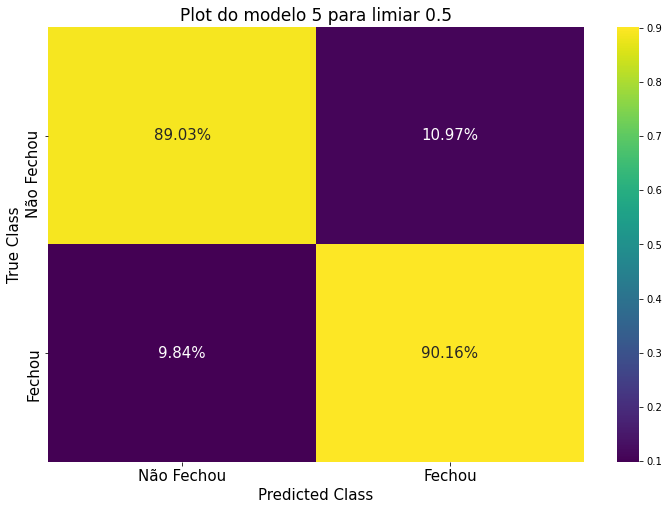

In [22]:
for i in range(5):
    plt.figure(figsize = (12,8))
    matriz = confusion_matrix(y_test, CV[i].predict(X_test[predict_model_cols]), normalize = "true")
    ax = sns.heatmap(matriz, cmap = "viridis", annot = True, annot_kws={"fontsize":15}, fmt=".2%")
    ax.set_title(f"Plot do modelo {i+1} para limiar 0.5", fontsize=17)
    ax.set_ylabel("True Class", fontsize=15)
    ax.set_xlabel("Predicted Class", fontsize=15)
    ax.set_xticklabels(["Não Fechou", "Fechou"], fontsize=15)
    ax.set_yticklabels(["Não Fechou", "Fechou"], fontsize=15)
    plt.show()
    "/n"


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


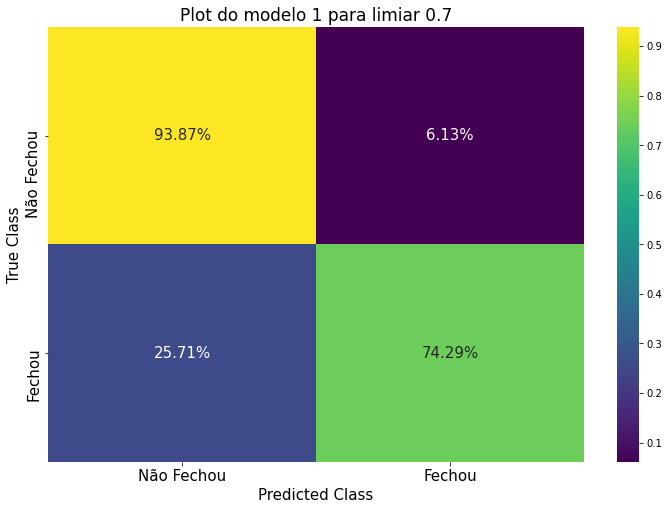


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


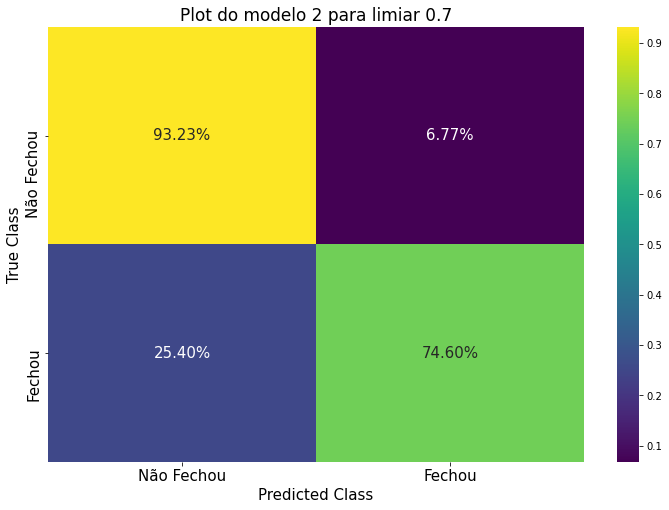


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


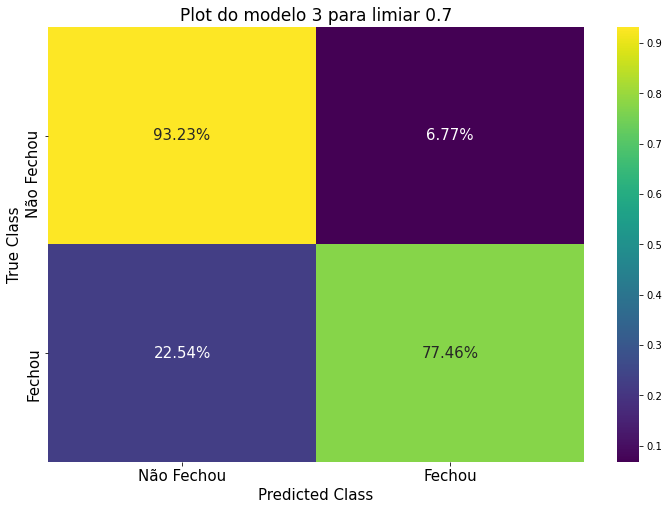


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


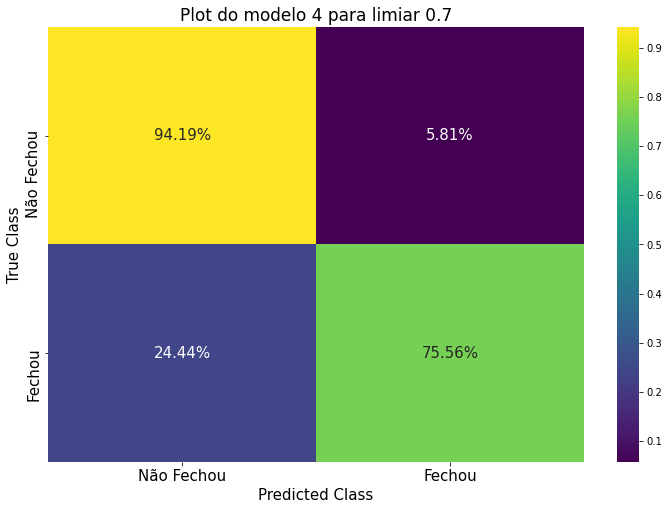


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


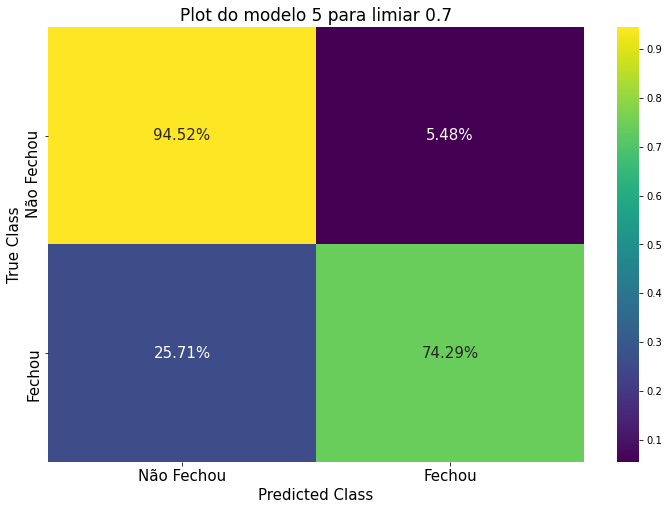


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
for i in range(5):
    # Separa os valores de teste
    X_test["probabilidade de pagar"] = CV[i].predict_proba(X_test[predict_model_cols])[:,1]
    X_test["Decisao_modelo"] = 0
    X_test.loc[X_test["probabilidade de pagar"] > 0.7, "Decisao_modelo"] = 1
    
    #Figura
    plt.figure(figsize = (12,8))
    matriz = confusion_matrix(y_test, X_test["Decisao_modelo"], normalize = "true")
    ax = sns.heatmap(matriz, cmap = "viridis", annot = True, annot_kws={"fontsize":15}, fmt=".2%")
    ax.set_title(f"Plot do modelo {i+1} para limiar 0.7", fontsize=17)
    ax.set_ylabel("True Class", fontsize=15)
    ax.set_xlabel("Predicted Class", fontsize=15)
    ax.set_xticklabels(["Não Fechou", "Fechou"], fontsize=15)
    ax.set_yticklabels(["Não Fechou", "Fechou"], fontsize=15)
    plt.show()
    plt.show()

    # Limpa o x_test
    X_test.drop(["probabilidade de pagar", "Decisao_modelo"], axis = 1, inplace = True)




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


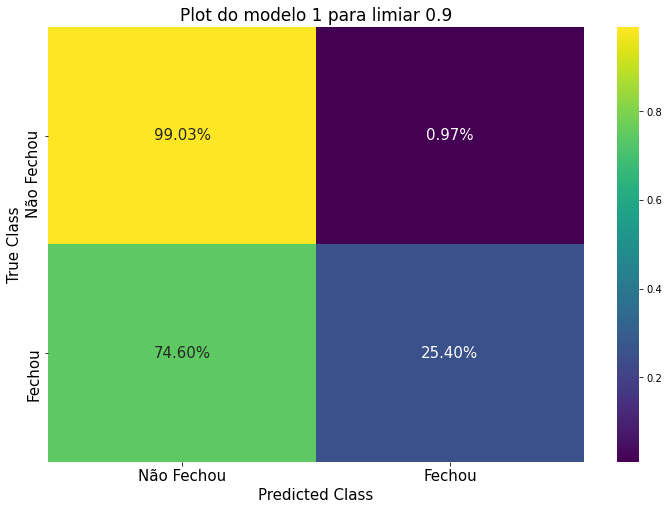


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


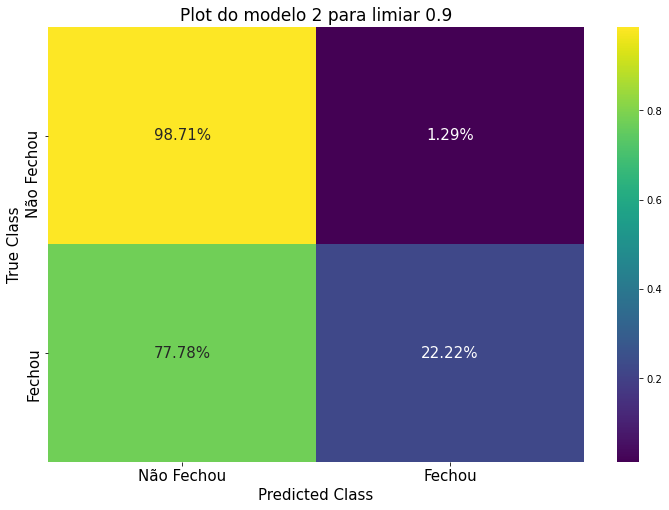


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


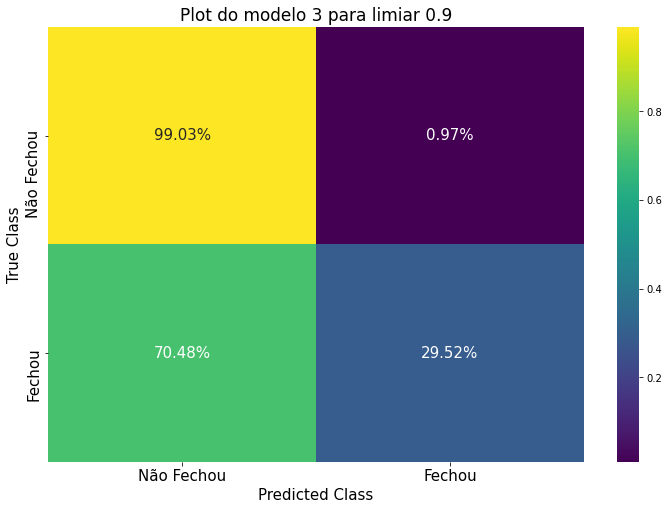


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


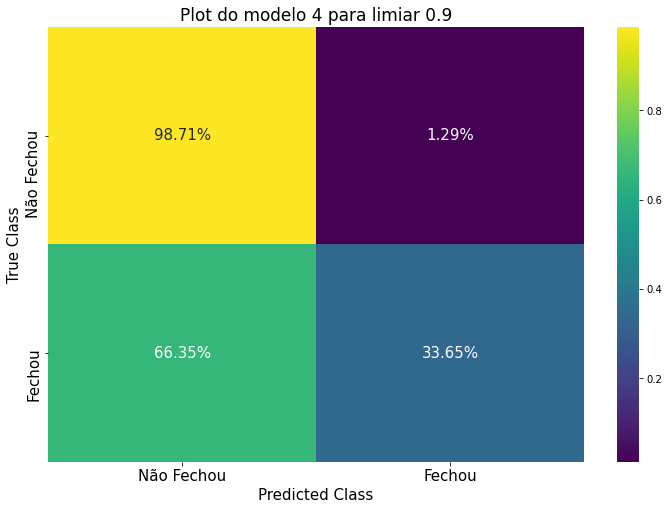


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


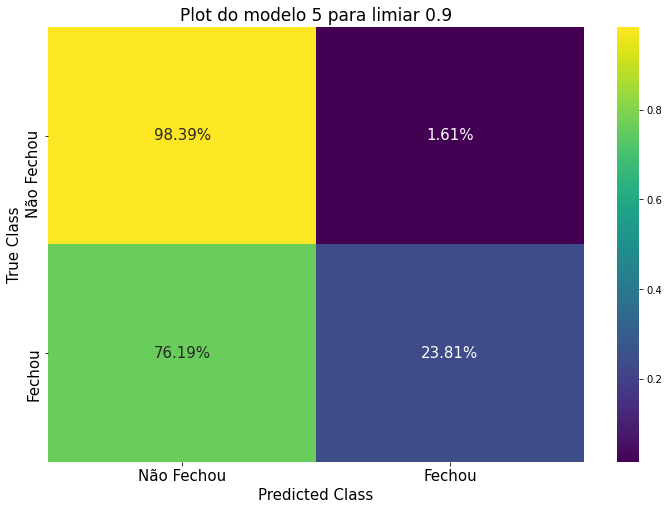


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [24]:
for i in range(5):
    # Separa os valores de teste
    X_test["probabilidade de pagar"] = CV[i].predict_proba(X_test[predict_model_cols])[:,1]
    X_test["Decisao_modelo"] = 0
    X_test.loc[X_test["probabilidade de pagar"] > 0.9, "Decisao_modelo"] = 1
    
    #Figura
    plt.figure(figsize = (12,8))
    matriz = confusion_matrix(y_test, X_test["Decisao_modelo"], normalize = "true")
    ax = sns.heatmap(matriz, cmap = "viridis", annot = True, annot_kws={"fontsize":15}, fmt=".2%")
    ax.set_title(f"Plot do modelo {i+1} para limiar 0.9", fontsize=17)
    ax.set_ylabel("True Class", fontsize=15)
    ax.set_xlabel("Predicted Class", fontsize=15)
    ax.set_xticklabels(["Não Fechou", "Fechou"], fontsize=15)
    ax.set_yticklabels(["Não Fechou", "Fechou"], fontsize=15)
    plt.show()
    plt.show()

    # Limpa o x_test
    X_test.drop(["probabilidade de pagar", "Decisao_modelo"], axis = 1, inplace = True)



In [25]:
# Classification Report
for i in range(5):
    print(classification_report(y_test,CV[i].predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       310
           1       0.88      0.89      0.88       315

    accuracy                           0.88       625
   macro avg       0.88      0.88      0.88       625
weighted avg       0.88      0.88      0.88       625

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       310
           1       0.89      0.87      0.88       315

    accuracy                           0.88       625
   macro avg       0.88      0.88      0.88       625
weighted avg       0.88      0.88      0.88       625

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       310
           1       0.89      0.90      0.89       315

    accuracy                           0.89       625
   macro avg       0.89      0.89      0.89       625
weighted avg       0.89      0.89      0.89       625

              preci

## Salvando o modelo

In [26]:
# Salvando os modelos
#date_tag = datetime.today().strftime('%Y-%m-%d')

#modelo = CV[4]

#file_name = "../../notebooks/LY_entrega/Modelo_completo_Random_forest_V3_LY_%s" %(date_tag)

#joblib.dump(modelo,file_name)

## Model Behavior

### Coefficients

In [27]:
df_coef = pd.DataFrame(CV[4].feature_importances_).T
df_coef.columns = X_test.columns
df_coef = df_coef.melt().sort_values('value')

In [28]:
df_coef

,variable,value
12,v_13,0.003429
9,v_10,0.027855
10,v_11,0.028686
3,v_4,0.031317
1,v_2,0.033483
6,v_7,0.040502
2,v_3,0.067651
4,v_5,0.074089
7,v_8,0.091441
5,v_6,0.095716


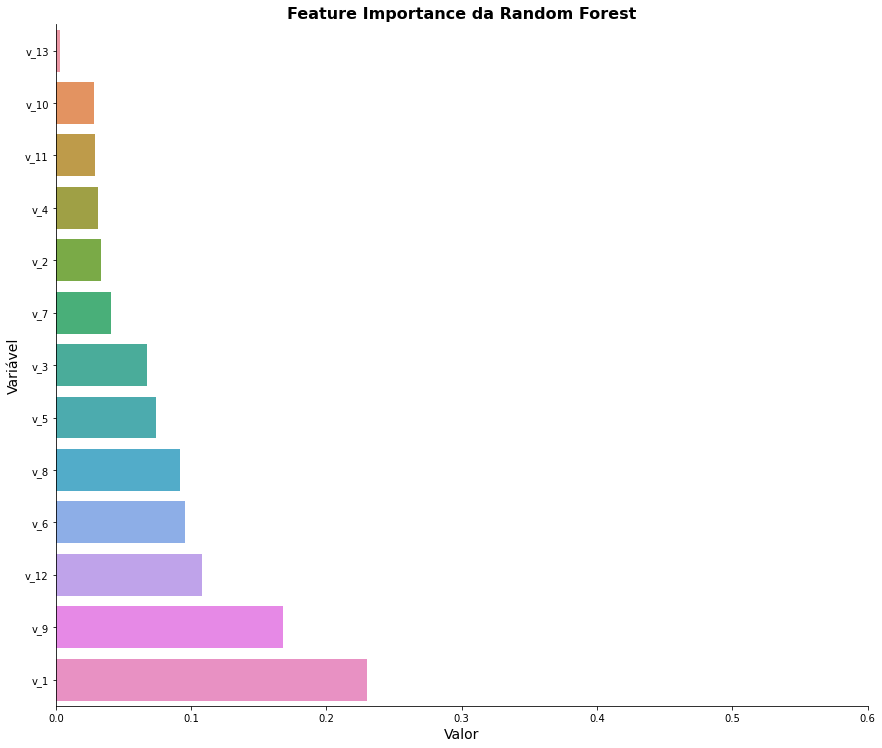

In [29]:
ax = sns.catplot(data = df_coef,
            x = 'value',
            y = 'variable',
            kind = 'bar',
           height = 10,
            aspect = 1.2)
plt.xlim(0,.6)
plt.title("Feature Importance da Random Forest", fontsize = 16, weight = 'bold')
ax.set_axis_labels(x_var = "Valor", y_var = "Variável", fontsize = 14)

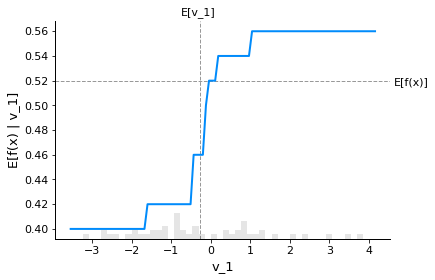

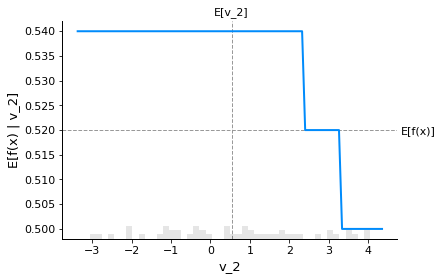

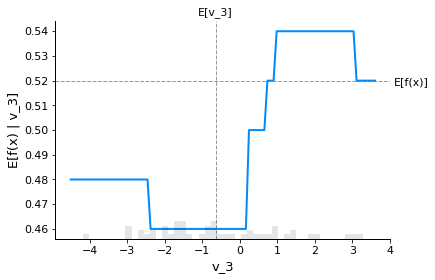

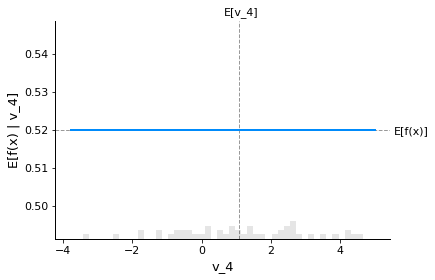

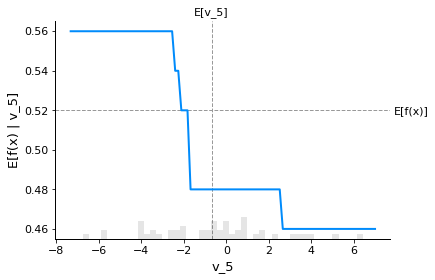

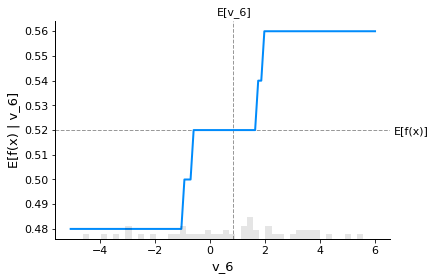

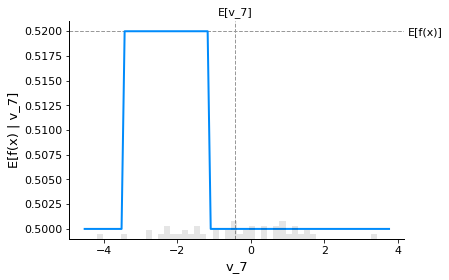

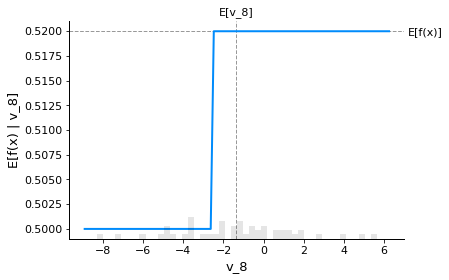

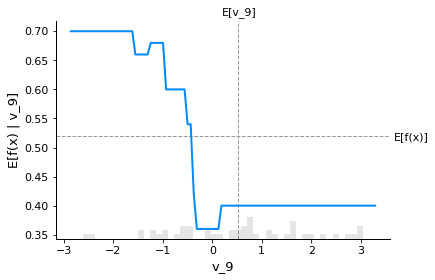

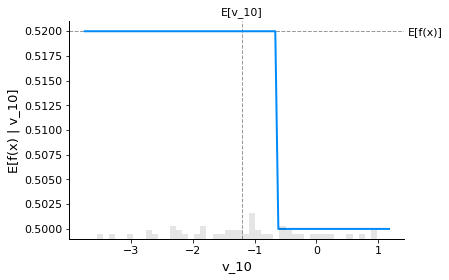

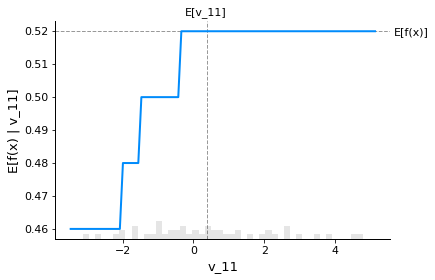

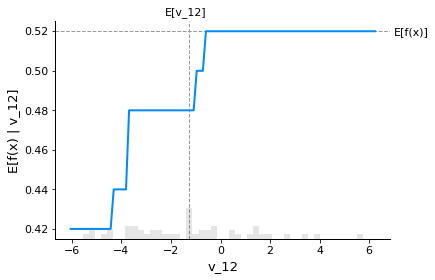

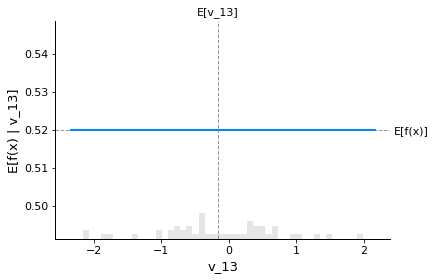

In [30]:
modelo = CV[4]
colunas = X_test.columns
X100 = shap.utils.sample(X_test, 50)
for icol in colunas:
    shap.plots.partial_dependence(
        icol, modelo.predict, X100, ice=False,
        model_expected_value=True, feature_expected_value=True
    )